#1. Desafio

A Telecom X está enfrentando uma taxa de evasão de clientes (churn) acima da média do setor. Perder clientes representa não apenas a perda de receita recorrente, mas também altos custos associados à aquisição de novos clientes para repor essa base. O objetivo central deste projeto é realizar uma análise exploratória de dados (EDA) para identificar os principais fatores e perfis de clientes que estão mais propensos a cancelar seus serviços.

Os insights gerados nesta análise servirão de base para que a equipe de Data Science possa, em uma fase posterior, construir modelos preditivos de churn e para que a área de negócio possa desenvolver estratégias de retenção mais eficazes e personalizadas.

##2. ETL: Extração, Transformação e Carga

Nesta fase, vamos nos conectar à fonte de dados, carregá-los em nosso ambiente de análise e prepará-los para a exploração.

###Passo 2.1: Extração (Extraction) - Importando os Dados da API

In [4]:
# Importando as bibliotecas necessárias
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# URL do arquivo JSON bruto (raw)
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"

# Fazendo a requisição para obter os dados
try:
    response = requests.get(url)
    response.raise_for_status()  # Lança um erro para status de falha (4xx ou 5xx)
    dados_json = response.json()
    print("Dados extraídos com sucesso da API.")
except requests.exceptions.RequestException as e:
    print(f"Erro ao acessar a API: {e}")
    dados_json = None

Dados extraídos com sucesso da API.


###Passo 2.2: Carga (Load) - Convertendo para DataFrame

Com os dados em formato JSON, o próximo passo é carregá-los em um DataFrame do Pandas, que é a estrutura ideal para manipulação e análise de dados tabulares.

In [6]:
if dados_json:
    # USANDO pd.json_normalize para "achatar" a estrutura aninhada
    # O separador '_' vai unir o nome da coluna principal com a sub-coluna (ex: account_tenure)
    df_normalizado = pd.json_normalize(dados_json, sep='_')

    # Visualizando as primeiras linhas do DataFrame já corrigido
    print("DataFrame normalizado com sucesso. Amostra dos dados:")
    display(df_normalizado.head())

    # Visualizando as informações gerais do DataFrame corrigido
    # Agora você verá todas as colunas!
    print("\nInformações Gerais do DataFrame Normalizado:")
    df_normalizado.info()

DataFrame normalizado com sucesso. Amostra dos dados:


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4



Informações Gerais do DataFrame Normalizado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  in

###Passo 2.3: Transformação (Transformation) - Limpeza e Preparação dos Dados

Esta é a etapa mais crítica do ETL. Com base na saída do df.info(), observamos alguns pontos que precisam de tratamento:

Coluna TotalGasto: Está classificada como object (texto), mas deveria ser numérica (float). Existem valores em branco que precisam ser tratados.

Coluna Churn: Contém "Sim" e "Não". É mais prático convertê-la para um formato numérico (1 para Sim, 0 para Não) para facilitar cálculos e visualizações.

Padronização: As colunas estão com nomes que misturam maiúsculas e minúsculas. Vamos padronizá-las para facilitar o acesso.

In [11]:
# Cópia do DataFrame para manter o original intacto
df_clean = df_normalizado.copy()

# 1. Tratamento da coluna 'account_TotalCharges'
# Converter para numérico, forçando erros (como strings vazias) a se tornarem NaN
df_clean['account_Charges_Total'] = pd.to_numeric(df_clean['account_Charges_Total'], errors='coerce')

# Verificar e tratar os valores nulos (clientes novos com tenure=0)
df_clean['account_Charges_Total'].fillna(0, inplace=True)
print("Coluna 'account_TotalCharges' tratada com sucesso.")


# 2. Tratamento da coluna 'Churn'
# Trocamos 'Sim' por 'Yes' para corresponder aos dados reais.
df_clean['Churn'] = df_clean['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("Coluna 'Churn' convertida corretamente para formato numérico (1/0).")

# Verificando a correção
print("\nContagem de valores na coluna 'Churn' após o ajuste:")
print(df_clean['Churn'].value_counts())

# Verificando as transformações
print("\nInformações do DataFrame após a limpeza:")
df_clean.info()

Coluna 'account_TotalCharges' tratada com sucesso.
Coluna 'Churn' convertida corretamente para formato numérico (1/0).

Contagem de valores na coluna 'Churn' após o ajuste:
Churn
0    5398
1    1869
Name: count, dtype: int64

Informações do DataFrame após a limpeza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   int64  
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   inter

/tmp/ipython-input-11-2211741592.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['account_Charges_Total'].fillna(0, inplace=True)


###2.4 Criando a Coluna Contas_Diarias

In [23]:
# Assumindo que um mês tem em média 30 dias
dias_no_mes = 30

# Criando a nova coluna 'Contas_Diarias'
df_clean['Contas_Diarias'] = df_clean['account_Charges_Monthly'] / dias_no_mes

# Verificando a criação da nova coluna
print("Coluna 'Contas_Diarias' criada com sucesso.")
print("Visualizando as colunas de cobrança Mensal e Diária lado a lado:")

# Usando .round(2) para arredondar para 2 casas decimais para melhor visualização
display(df_clean[['account_Charges_Monthly', 'Contas_Diarias']].round(2).head())

Coluna 'Contas_Diarias' criada com sucesso.
Visualizando as colunas de cobrança Mensal e Diária lado a lado:


,account_Charges_Monthly,Contas_Diarias
0,65.6,2.19
1,59.9,2.00
2,73.9,2.46
3,98.0,3.27
4,83.9,2.80


##3. Análise Exploratória de Dados (EDA) e Visualizações

Agora que nossos dados estão limpos e estruturados, podemos começar a explorá-los para encontrar padrões relacionados à evasão de clientes.

###3.1. Visão Geral do Churn

Primeiro, vamos entender a proporção de clientes que cancelaram o serviço.

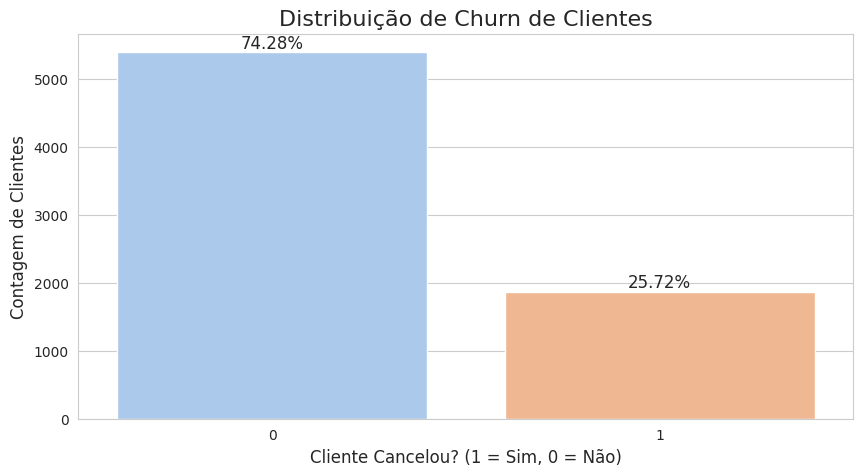

In [12]:
# Configurações de visualização
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))

# Calculando a taxa de churn
churn_rate = df_clean['Churn'].value_counts(normalize=True) * 100

# Gráfico de barras para visualizar a contagem
# Ajuste para remover o "FutureWarning"
ax = sns.countplot(data=df_clean, x='Churn', hue='Churn', palette='pastel', legend=False)
ax.set_title('Distribuição de Churn de Clientes', fontsize=16)
ax.set_xlabel('Cliente Cancelou? (1 = Sim, 0 = Não)', fontsize=12)
ax.set_ylabel('Contagem de Clientes', fontsize=12)

# Adicionando os percentuais no gráfico (agora vai funcionar)
ax.text(0, df_clean['Churn'].value_counts()[0], f'{churn_rate[0]:.2f}%', ha='center', va='bottom', fontsize=12)
ax.text(1, df_clean['Churn'].value_counts()[1], f'{churn_rate[1]:.2f}%', ha='center', va='bottom', fontsize=12)

plt.show()

Insight Imediato: A taxa de churn é de aproximadamente 25,72%, um valor considerável que justifica a preocupação da Telecom X.

###3.2. Churn vs. Características Contratuais

O tipo de contrato e a forma de pagamento costumam ser fortes indicadores de churn.

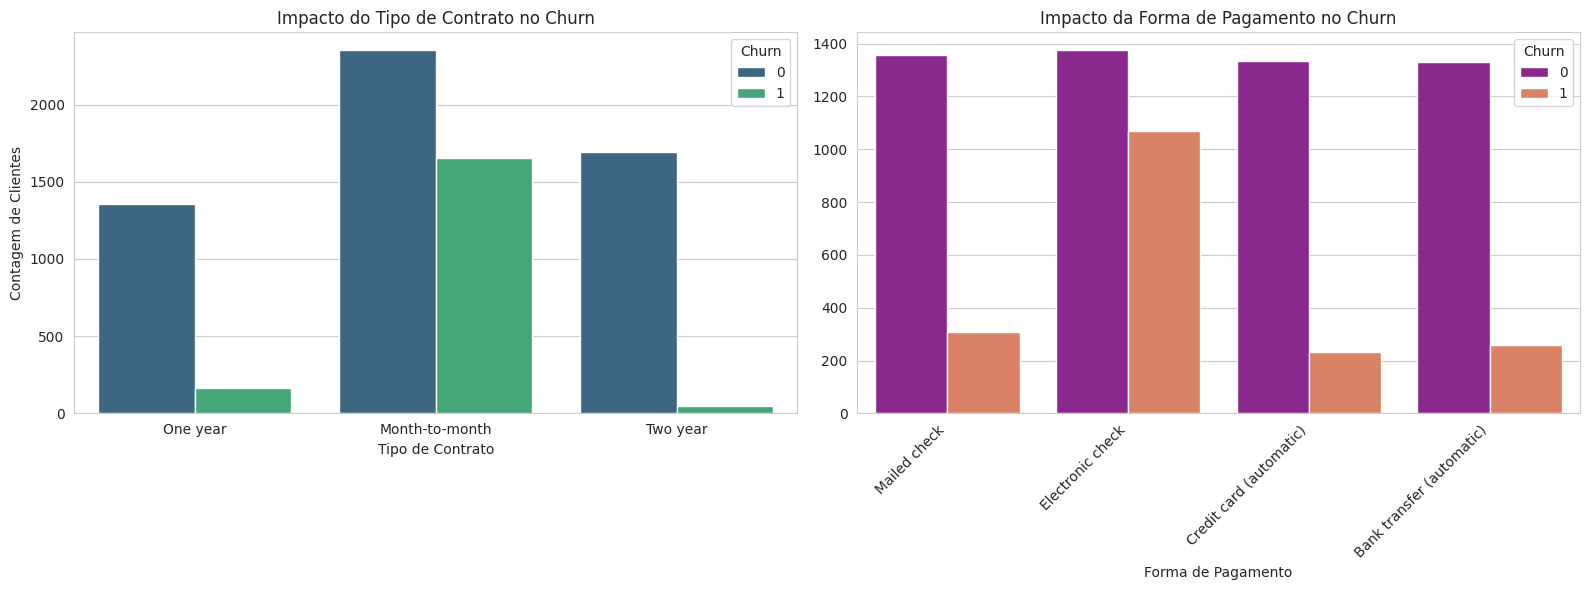

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Churn por Tipo de Contrato
sns.countplot(x='account_Contract', hue='Churn', data=df_clean, ax=axes[0], palette='viridis')
axes[0].set_title('Impacto do Tipo de Contrato no Churn')
axes[0].set_xlabel('Tipo de Contrato')
axes[0].set_ylabel('Contagem de Clientes')

# Churn por Forma de Pagamento
sns.countplot(x='account_PaymentMethod', hue='Churn', data=df_clean, ax=axes[1], palette='plasma')
axes[1].set_title('Impacto da Forma de Pagamento no Churn')
axes[1].set_xlabel('Forma de Pagamento')
axes[1].set_ylabel('')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Insights:

* Tipo de Contrato: Clientes com contrato mensal têm uma taxa de churn absurdamente maior em comparação com contratos de um ou dois anos. Isso indica que não há uma barreira de longo prazo para o cancelamento.

* Forma de Pagamento: Clientes que utilizam cheque eletrônico como forma de pagamento apresentam a maior taxa de evasão, sugerindo uma possível insatisfação com o método ou uma menor fidelidade.

###3.3. Churn vs. Características Demográficas e de Serviços

Vamos analisar como o perfil demográfico e os serviços contratados se relacionam com o churn.

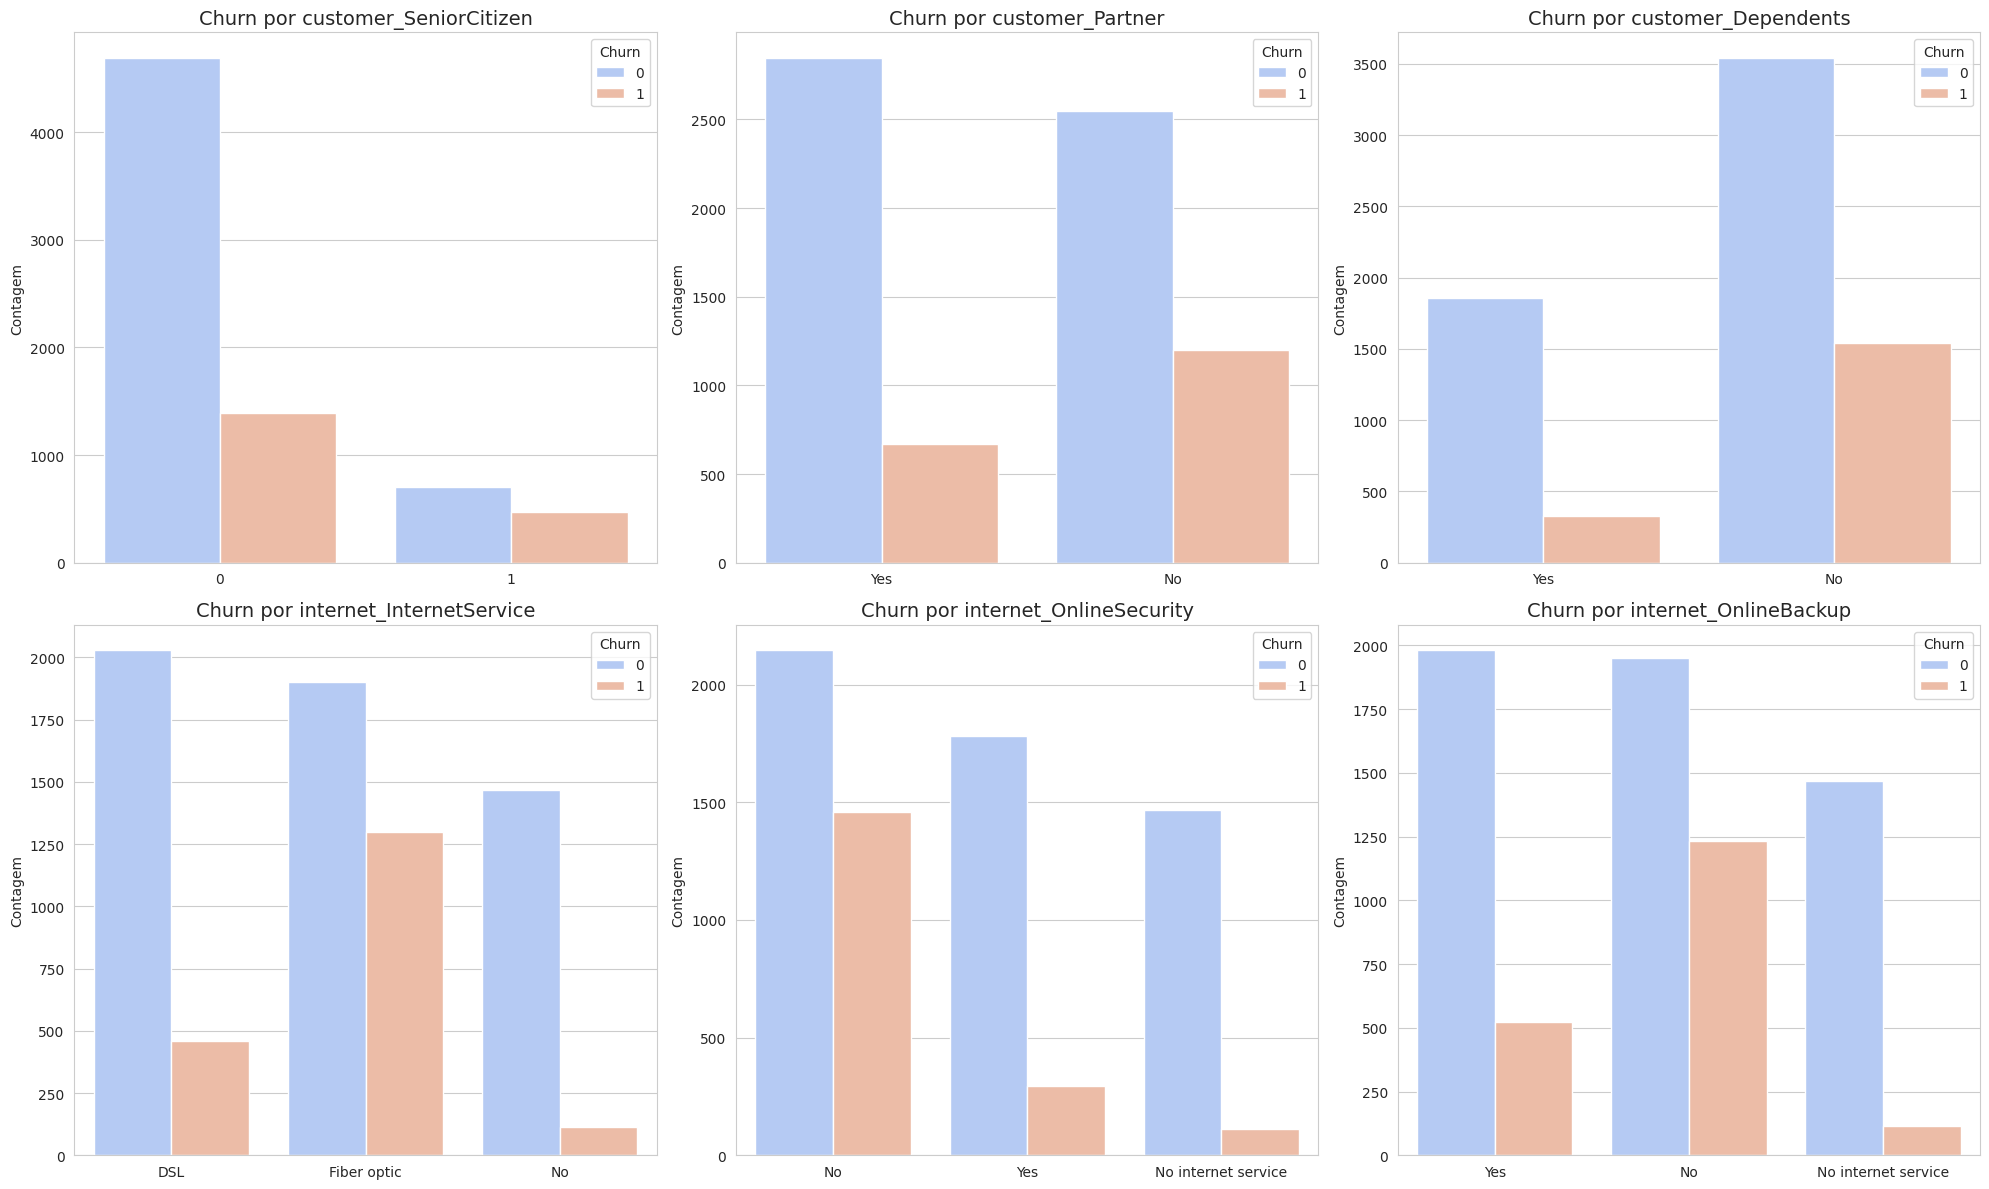

In [20]:
# Lista de colunas categóricas para análise
cat_cols = ['customer_SeniorCitizen','customer_Partner','customer_Dependents','internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='Churn', data=df_clean, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Churn por {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Contagem')

plt.tight_layout()
plt.show()

Insights:

* Idosos: Clientes idosos (Idoso = 1) têm uma taxa de churn proporcionalmente maior.

* Parceiro e Dependentes: Clientes solteiros e sem dependentes tendem a cancelar mais. Isso sugere que clientes com vínculos familiares são mais estáveis.

* Serviço de Internet: Clientes com Fibra Óptica cancelam mais do que os com DSL. Isso pode parecer contraintuitivo, mas pode estar ligado a preços mais altos, instabilidade na entrega do serviço ou concorrência agressiva nesse segmento.

* Serviços de Proteção: Clientes sem serviços de valor agregado como Segurança Online e Backup Online apresentam taxas de churn significativamente mais altas.

###3.4. Churn vs. Variáveis Numéricas (Tempo de Contrato e Gastos)

Analisar a distribuição de variáveis numéricas para clientes que cancelaram vs. os que não cancelaram.

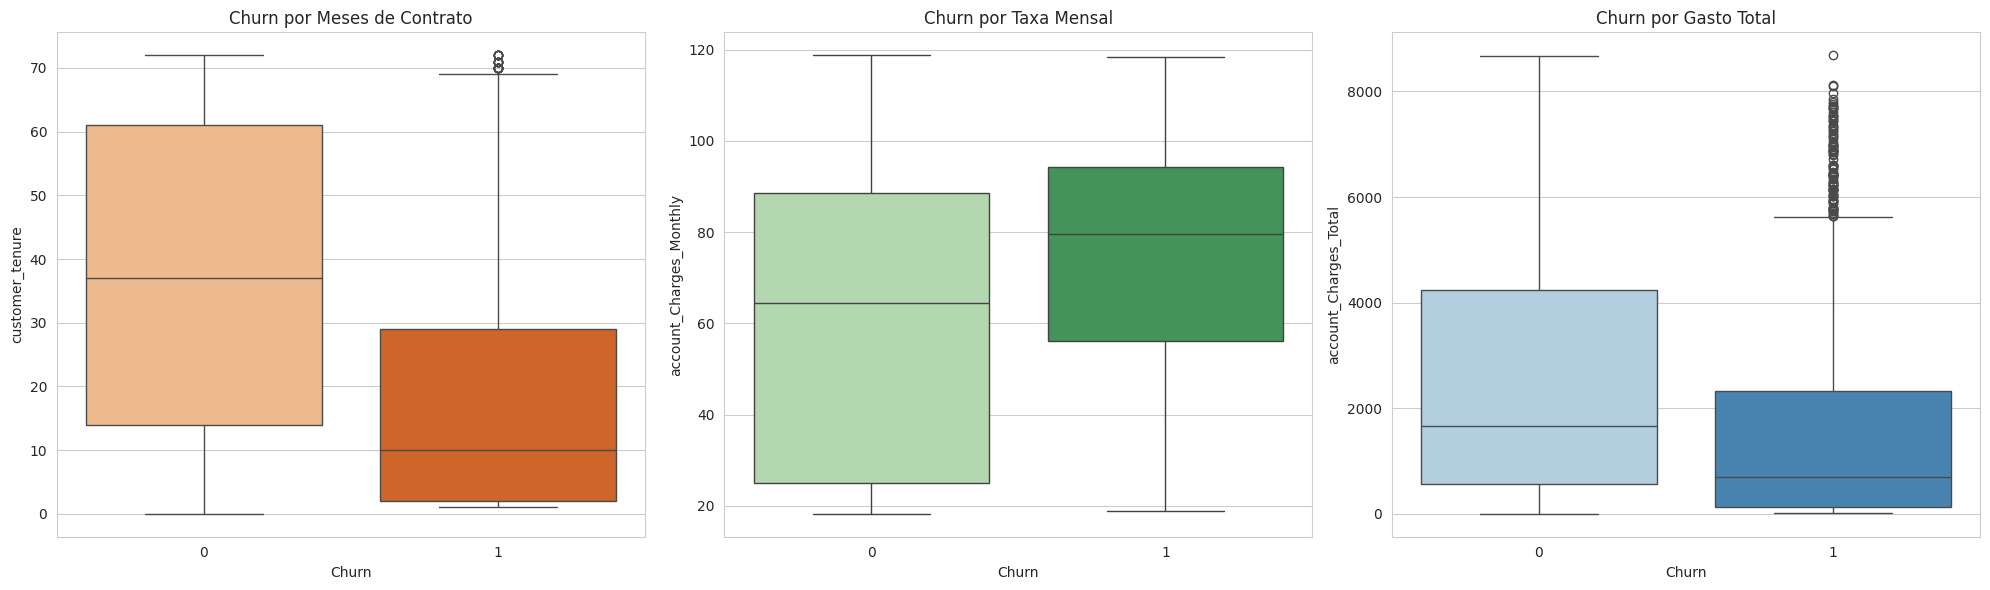

In [22]:
# Célula de código para Google Colab

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Meses de Contrato (Tenure)
sns.boxplot(x='Churn', y='customer_tenure', data=df_clean, ax=axes[0], palette='Oranges')
axes[0].set_title('Churn por Meses de Contrato')

# Taxa Mensal
sns.boxplot(x='Churn', y='account_Charges_Monthly', data=df_clean, ax=axes[1], palette='Greens')
axes[1].set_title('Churn por Taxa Mensal')

# Gasto Total
sns.boxplot(x='Churn', y='account_Charges_Total', data=df_clean, ax=axes[2], palette='Blues')
axes[2].set_title('Churn por Gasto Total')

plt.tight_layout()
plt.show()

Insights:

* Meses de Contrato: Confirma a análise anterior. Clientes que cancelam têm, em média, um tempo de contrato muito menor. A evasão é um fenômeno que ocorre predominantemente no início da jornada do cliente.

* Taxa Mensal: Clientes que cancelam tendem a ter uma taxa mensal mais alta. Isso pode indicar uma percepção de baixo custo-benefício.

* Gasto Total: Clientes que cancelam possuem um gasto total acumulado significativamente menor, o que é uma consequência direta de terem ficado menos tempo na empresa.

###3.5 Análise de Correlação

A análise de correlação nos ajuda a entender como as variáveis numéricas do nosso conjunto de dados se movem em conjunto. Uma matriz de correlação, visualizada como um heatmap (mapa de calor), é a melhor ferramenta para isso.

Valores próximos de +1: Indicam uma forte correlação positiva (quando uma variável aumenta, a outra também tende a aumentar).

Valores próximos de -1: Indicam uma forte correlação negativa (quando uma variável aumenta, a outra tende a diminuir).

Valores próximos de 0: Indicam pouca ou nenhuma correlação linear.

In [24]:
# Selecionando apenas as colunas numéricas para a análise de correlação
colunas_numericas = df_clean.select_dtypes(include=['int64', 'float64']).columns
df_corr = df_clean[colunas_numericas]

# Calculando a matriz de correlação
matriz_correlacao = df_corr.corr()

print("Matriz de Correlação calculada:")
display(matriz_correlacao)

Matriz de Correlação calculada:


,Churn,customer_SeniorCitizen,customer_tenure,account_Charges_Monthly,account_Charges_Total,Contas_Diarias
Churn,1.000000,0.146733,-0.344079,0.189866,-0.193345,0.189866
customer_SeniorCitizen,0.146733,1.000000,0.018187,0.220388,0.104076,0.220388
customer_tenure,-0.344079,0.018187,1.000000,0.247982,0.825407,0.247982
account_Charges_Monthly,0.189866,0.220388,0.247982,1.000000,0.652211,1.000000
account_Charges_Total,-0.193345,0.104076,0.825407,0.652211,1.000000,0.652211
Contas_Diarias,0.189866,0.220388,0.247982,1.000000,0.652211,1.000000


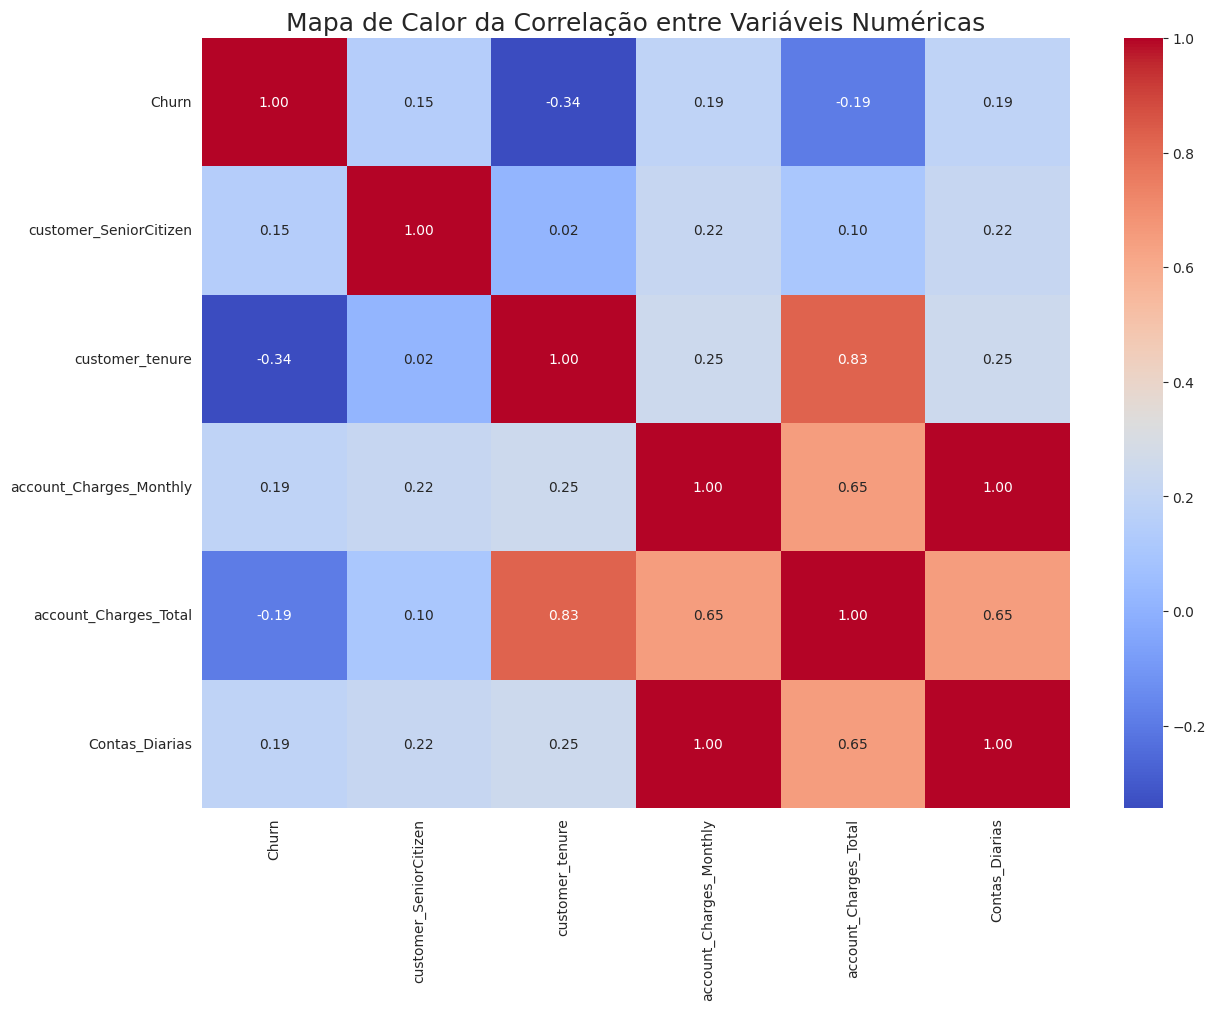

In [25]:
# Configurando o tamanho da figura
plt.figure(figsize=(14, 10))

# Criando o heatmap com o Seaborn
# Usamos um mapa de cores "coolwarm" que vai de azul (negativo) a vermelho (positivo)
heatmap = sns.heatmap(matriz_correlacao, annot=True, fmt='.2f', cmap='coolwarm')
heatmap.set_title('Mapa de Calor da Correlação entre Variáveis Numéricas', fontsize=18)

plt.show()

In [26]:
# Exibindo a correlação de todas as variáveis com o Churn, de forma ordenada
correlacao_churn = matriz_correlacao['Churn'].sort_values(ascending=False)

print("Correlação das variáveis com o Churn:")
display(correlacao_churn)

Correlação das variáveis com o Churn:


,Churn
Churn,1.000000
Contas_Diarias,0.189866
account_Charges_Monthly,0.189866
customer_SeniorCitizen,0.146733
account_Charges_Total,-0.193345
customer_tenure,-0.344079


##4. Relatório Final de Análise e Insights

A análise exploratória dos dados de clientes da Telecom X revelou padrões claros e acionáveis que ajudam a explicar a alta taxa de churn de 25,72%. Os insights mais relevantes são:

Principais Fatores de Risco para o Churn:

Perfil Contratual:

Contrato Mensal: É o principal indicador de risco. Clientes sem um vínculo de longo prazo são extremamente voláteis.

Pagamento com Cheque Eletrônico: Este método de pagamento está fortemente correlacionado com o churn, indicando possível atrito ou um perfil de cliente menos engajado.

Perfil de Cliente e Tempo de Casa:

Clientes Novos: A evasão é massivamente concentrada nos primeiros meses de serviço. O "período de encantamento" inicial parece estar falhando.

Clientes sem Vínculos: Clientes solteiros (Parceiro = Não) e sem dependentes financeiros (Dependentes = Não) possuem maior probabilidade de cancelamento.

Serviços e Custos:

Falta de Serviços de Valor Agregado: A ausência de serviços como SegurancaOnline e BackupOnline é um forte indicador de churn. Clientes com o "pacote básico" não percebem valor suficiente para permanecer.

Taxas Mensais Elevadas: Clientes com mensalidades mais altas, especialmente aqueles com internet de Fibra Óptica, tendem a cancelar mais. Isso sugere uma sensibilidade ao preço ou uma percepção de que o valor entregue não justifica o custo.

Recomendações e Próximos Passos para a Equipe de Data Science:

Engenharia de Atributos (Feature Engineering): Criar novas variáveis pode enriquecer o modelo preditivo. Sugestões:

relacao_taxa_total: TaxaMensal / TotalGasto para identificar clientes com alto custo recente.

num_servicos_adicionais: Contagem de serviços extras contratados.

Modelagem Preditiva: Os dados estão prontos para a próxima fase. Recomenda-se iniciar com modelos como:

Regressão Logística: Para criar um baseline e entender o peso de cada variável de forma interpretável.

Modelos baseados em Árvores (Random Forest, XGBoost): Para capturar interações complexas entre as variáveis e obter maior acurácia preditiva. A análise de feature importance desses modelos servirá para validar e quantificar os achados desta EDA.

Foco Estratégico: A análise sugere que as estratégias de retenção devem ser focadas em:

Clientes em Contratos Mensais: Oferecer incentivos para migração para contratos de 1 ou 2 anos.

Primeiros Meses (Onboarding): Melhorar a experiência inicial do cliente para aumentar o engajamento.

Upsell de Serviços de Proteção: Promover ativamente serviços como Segurança e Backup Online para clientes com pacotes básicos, aumentando o "lock-in" (fator de aprisionamento).